In [19]:
import scipy.io as spio
import matplotlib.pyplot as plt
import sys
import warnings
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from math import log
import numpy as np
import numpy.testing as npt
from numpy import isneginf
np.seterr(divide='ignore')
import scipy
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [20]:
d4train1000_data = spio.loadmat('d4_q1.mat')['data']

d4test10k_data = spio.loadmat('d4_q1test.mat')['test']

In [21]:
def tenFoldCrossVal(data):
    
    
    #Attach labels to data
    X = data[0]
    y = data[1]
    
    print(X[:10], y[:10])
    #mscaler = Normalizer()
    #dtrain = mscaler.fit_transform(dtrain)
    
    #Split the data in 10 batches
    sizeBatches = 10
    kf = KFold(n_splits=sizeBatches, shuffle=True)
    kf.get_n_splits(X)
    
    cost_matrix = np.zeros((6,2))
    #accuracy_matrix = np.zeros((6,2))
    full_a_matrix = []
    perceptronList = np.arange(4, 5)
    
    
    for numPerceptrons in perceptronList:

        for train_index, test_index in kf.split(X):
            train_data, test_data = X[train_index], X[test_index]
            train_labels, test_labels = y[train_index], y[test_index]

            
            accuracy_matrix = []

            #Some Preprocessing, Scale data between 0 and 1
            #mscaler = MinMaxScaler()
            #train_data = mscaler.fit_transform(train_data)
            #test_data = mscaler.fit_transform(test_data)

            hm_epochs = 200
            adam_o = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
            sgd_o = keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False)
            rU = keras.initializers.RandomUniform(minval=-10, maxval=10)
            xavier = keras.initializers.glorot_normal(seed=None)
            he = keras.initializers.he_normal(seed=None)

            t_cost = 0
            model = Sequential()
            model.add(Dense(numPerceptrons, input_dim=1, activation='softplus', 
                            kernel_initializer=xavier,
                            bias_initializer='zeros'))

            model.add(Dense(1, activation=None,
                                kernel_initializer=xavier,
                                bias_initializer='zeros'))
            model.compile(loss='mean_squared_error', optimizer=sgd_o,
                          metrics=['mean_squared_error'])

            model.summary()

            #Fit Model
            history = model.fit(train_data, train_labels, 
                                epochs=hm_epochs, 
                                verbose=1)
            
            #results = cross_val_score(history, train_data, train_labels, cv=kfold)
            #print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))
            #Test Model
            #model = baseline_model()
            y_hat = model.predict(X, batch_size=10)
            plt.figure()
            plt.plot(X, y, 'b.')
            plt.scatter(X, y_hat, c='r')
            #print(y_hat)
            #truth = np.concatenate((test_labels, y_hat), axis=1)
            a = model.evaluate(test_data, test_labels)
            accuracy_matrix.append(a[0])
            #print(a)
            
            
        
        accuracy_matrix = np.mean(np.array(accuracy_matrix), axis=0)
        full_a_matrix.append(np.array(accuracy_matrix))
        
    print(full_a_matrix)
    
    p_hat = perceptronList[np.argmin(full_a_matrix)]
    
    return p_hat

In [22]:
def baseline_model():
    adam_o = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model = Sequential()
    model.add(Dense(6, input_dim=1, activation='softplus', 
                    kernel_initializer='normal',
                    bias_initializer='zeros'))

    model.add(Dense(1, activation=None,
                        kernel_initializer='normal',
                        bias_initializer='zeros'))
    model.compile(loss='mean_squared_error', optimizer=adam_o,
                  metrics=['mean_squared_error'])

    return model

In [34]:
def fitAndTest(p_hat, training_set, test_set):
    
    train_data = training_set[:, :1]
    train_labels = training_set[:, 1:]

    test_data =  test_set[:, :1]
    test_labels = test_set[:, 1:]
    
    hm_epochs = 100
    adam_o = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    sgd_o = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
    rU = keras.initializers.RandomUniform(minval=-3, maxval=3, seed=0)
    xavier = keras.initializers.glorot_normal(seed=None)
    he = keras.initializers.he_normal(seed=None)

    t_cost = 0
    model = Sequential()
    model.add(Dense(p_hat, input_dim=1, activation='softplus', 
                    kernel_initializer= xavier,
                    bias_initializer='zeros'))

    model.add(Dense(1, activation='linear',
                        kernel_initializer= xavier,
                        bias_initializer='zeros'))
    model.compile(loss='mean_squared_error', optimizer=sgd_o,
                  metrics=['mean_squared_error'])

    model.summary()

    #Fit Model
    history = model.fit(train_data, train_labels, 
                        epochs=hm_epochs, 
                        verbose=0)
    #Evaluate model
    a = model.evaluate(test_data, test_labels)
    print(a)
    y_hat = model.predict(test_data)
    plt.figure()
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.plot(test_data, test_labels, 'b.', zorder=1)
    plt.scatter(test_data, y_hat, c='r', zorder=2)
    plt.savefig("HW4_Q1")
    npt.assert_almost_equal(y_hat, test_labels, decimal=4)

[ -4.76544339   6.1239748   -0.77163573  -0.20867931 -12.38691893
   0.31139712  -1.30950345   2.778285   -10.16803237  -8.53111454] [-0.80159426 -0.23711395 -0.76379922 -0.46556711 -3.02040771 -0.95409999
  2.55324283  0.35246765 -4.81732226 -3.6796052 ]
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 5         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
900/900 [==============================] - 0s 104us/step - loss: 4.2133 - mean_squared_error: 4.2133
Epoch 2/200
900/900 [==============================] - 0s 50us/step - loss: 3.1943 - mean_squared_error: 3.1943
Epoch 3/200
900/900 [=================

900/900 [==============================] - 0s 70us/step - loss: 1.6730 - mean_squared_error: 1.6730
Epoch 66/200
900/900 [==============================] - 0s 132us/step - loss: 1.6659 - mean_squared_error: 1.6659
Epoch 67/200
900/900 [==============================] - 0s 81us/step - loss: 1.6665 - mean_squared_error: 1.6665
Epoch 68/200
900/900 [==============================] - 0s 53us/step - loss: 1.6617 - mean_squared_error: 1.6617
Epoch 69/200
900/900 [==============================] - 0s 41us/step - loss: 1.6649 - mean_squared_error: 1.6649
Epoch 70/200
900/900 [==============================] - 0s 38us/step - loss: 1.6497 - mean_squared_error: 1.6497
Epoch 71/200
900/900 [==============================] - 0s 39us/step - loss: 1.6547 - mean_squared_error: 1.6547
Epoch 72/200
900/900 [==============================] - 0s 37us/step - loss: 1.6610 - mean_squared_error: 1.6610
Epoch 73/200
900/900 [==============================] - 0s 40us/step - loss: 1.6514 - mean_squared_error: 1.

900/900 [==============================] - 0s 41us/step - loss: 1.6005 - mean_squared_error: 1.6005
Epoch 138/200
900/900 [==============================] - 0s 42us/step - loss: 1.5914 - mean_squared_error: 1.5914
Epoch 139/200
900/900 [==============================] - 0s 47us/step - loss: 1.6039 - mean_squared_error: 1.6039
Epoch 140/200
900/900 [==============================] - 0s 52us/step - loss: 1.6031 - mean_squared_error: 1.6031
Epoch 141/200
900/900 [==============================] - 0s 46us/step - loss: 1.5944 - mean_squared_error: 1.5944
Epoch 142/200
900/900 [==============================] - 0s 49us/step - loss: 1.5965 - mean_squared_error: 1.5965
Epoch 143/200
900/900 [==============================] - 0s 44us/step - loss: 1.5902 - mean_squared_error: 1.5902
Epoch 144/200
900/900 [==============================] - 0s 47us/step - loss: 1.5968 - mean_squared_error: 1.5968
Epoch 145/200
900/900 [==============================] - 0s 53us/step - loss: 1.5911 - mean_squared_er

900/900 [==============================] - 0s 52us/step - loss: 6.5649 - mean_squared_error: 6.5649
Epoch 4/200
900/900 [==============================] - 0s 49us/step - loss: 6.4433 - mean_squared_error: 6.4433
Epoch 5/200
900/900 [==============================] - 0s 36us/step - loss: 6.3447 - mean_squared_error: 6.3447
Epoch 6/200
900/900 [==============================] - 0s 36us/step - loss: 6.2400 - mean_squared_error: 6.2400
Epoch 7/200
900/900 [==============================] - 0s 34us/step - loss: 6.1496 - mean_squared_error: 6.1496
Epoch 8/200
900/900 [==============================] - 0s 33us/step - loss: 6.0596 - mean_squared_error: 6.0596
Epoch 9/200
900/900 [==============================] - 0s 33us/step - loss: 5.9908 - mean_squared_error: 5.9908
Epoch 10/200
900/900 [==============================] - 0s 32us/step - loss: 5.9170 - mean_squared_error: 5.9170
Epoch 11/200
900/900 [==============================] - 0s 32us/step - loss: 5.8521 - mean_squared_error: 5.8521
Ep

900/900 [==============================] - 0s 36us/step - loss: 3.6132 - mean_squared_error: 3.6132
Epoch 76/200
900/900 [==============================] - 0s 33us/step - loss: 3.5815 - mean_squared_error: 3.5815
Epoch 77/200
900/900 [==============================] - 0s 33us/step - loss: 3.5494 - mean_squared_error: 3.5494
Epoch 78/200
900/900 [==============================] - 0s 34us/step - loss: 3.5377 - mean_squared_error: 3.5377
Epoch 79/200
900/900 [==============================] - 0s 33us/step - loss: 3.5081 - mean_squared_error: 3.5081
Epoch 80/200
900/900 [==============================] - 0s 34us/step - loss: 3.4848 - mean_squared_error: 3.4848
Epoch 81/200
900/900 [==============================] - 0s 36us/step - loss: 3.4709 - mean_squared_error: 3.4709
Epoch 82/200
900/900 [==============================] - 0s 33us/step - loss: 3.4349 - mean_squared_error: 3.4349
Epoch 83/200
900/900 [==============================] - 0s 33us/step - loss: 3.4255 - mean_squared_error: 3.4

900/900 [==============================] - 0s 33us/step - loss: 2.5889 - mean_squared_error: 2.5889
Epoch 148/200
900/900 [==============================] - 0s 36us/step - loss: 2.5914 - mean_squared_error: 2.5914
Epoch 149/200
900/900 [==============================] - 0s 33us/step - loss: 2.5831 - mean_squared_error: 2.5831
Epoch 150/200
900/900 [==============================] - 0s 33us/step - loss: 2.5645 - mean_squared_error: 2.5645
Epoch 151/200
900/900 [==============================] - 0s 34us/step - loss: 2.5611 - mean_squared_error: 2.5611
Epoch 152/200
900/900 [==============================] - 0s 33us/step - loss: 2.5513 - mean_squared_error: 2.5513
Epoch 153/200
900/900 [==============================] - 0s 36us/step - loss: 2.5493 - mean_squared_error: 2.5493
Epoch 154/200
900/900 [==============================] - 0s 33us/step - loss: 2.5438 - mean_squared_error: 2.5438
Epoch 155/200
900/900 [==============================] - 0s 34us/step - loss: 2.5642 - mean_squared_er

900/900 [==============================] - 0s 36us/step - loss: 2.6665 - mean_squared_error: 2.6665
Epoch 14/200
900/900 [==============================] - 0s 88us/step - loss: 2.5658 - mean_squared_error: 2.5658
Epoch 15/200
900/900 [==============================] - 0s 68us/step - loss: 2.4871 - mean_squared_error: 2.4871
Epoch 16/200
900/900 [==============================] - 0s 40us/step - loss: 2.4086 - mean_squared_error: 2.4086
Epoch 17/200
900/900 [==============================] - 0s 40us/step - loss: 2.3436 - mean_squared_error: 2.3436
Epoch 18/200
900/900 [==============================] - 0s 42us/step - loss: 2.2808 - mean_squared_error: 2.2808
Epoch 19/200
900/900 [==============================] - 0s 42us/step - loss: 2.2318 - mean_squared_error: 2.2318
Epoch 20/200
900/900 [==============================] - 0s 50us/step - loss: 2.1798 - mean_squared_error: 2.1798
Epoch 21/200
900/900 [==============================] - 0s 41us/step - loss: 2.1414 - mean_squared_error: 2.1

900/900 [==============================] - 0s 37us/step - loss: 1.6273 - mean_squared_error: 1.6273
Epoch 86/200
900/900 [==============================] - 0s 38us/step - loss: 1.6168 - mean_squared_error: 1.6168
Epoch 87/200
900/900 [==============================] - 0s 37us/step - loss: 1.6155 - mean_squared_error: 1.6155
Epoch 88/200
900/900 [==============================] - 0s 36us/step - loss: 1.6155 - mean_squared_error: 1.6155
Epoch 89/200
900/900 [==============================] - 0s 38us/step - loss: 1.6161 - mean_squared_error: 1.6161
Epoch 90/200
900/900 [==============================] - 0s 38us/step - loss: 1.6105 - mean_squared_error: 1.6105
Epoch 91/200
900/900 [==============================] - 0s 38us/step - loss: 1.6136 - mean_squared_error: 1.6136
Epoch 92/200
900/900 [==============================] - 0s 36us/step - loss: 1.6115 - mean_squared_error: 1.6115
Epoch 93/200
900/900 [==============================] - 0s 37us/step - loss: 1.6094 - mean_squared_error: 1.6

900/900 [==============================] - 0s 42us/step - loss: 1.5752 - mean_squared_error: 1.5752
Epoch 158/200
900/900 [==============================] - 0s 38us/step - loss: 1.5759 - mean_squared_error: 1.5759
Epoch 159/200
900/900 [==============================] - 0s 36us/step - loss: 1.5741 - mean_squared_error: 1.5741
Epoch 160/200
900/900 [==============================] - 0s 36us/step - loss: 1.5754 - mean_squared_error: 1.5754
Epoch 161/200
900/900 [==============================] - 0s 37us/step - loss: 1.5745 - mean_squared_error: 1.5745
Epoch 162/200
900/900 [==============================] - 0s 38us/step - loss: 1.5727 - mean_squared_error: 1.5727
Epoch 163/200
900/900 [==============================] - 0s 37us/step - loss: 1.5733 - mean_squared_error: 1.5733
Epoch 164/200
900/900 [==============================] - 0s 36us/step - loss: 1.5692 - mean_squared_error: 1.5692
Epoch 165/200
900/900 [==============================] - 0s 36us/step - loss: 1.5699 - mean_squared_er

900/900 [==============================] - 0s 34us/step - loss: 1.8590 - mean_squared_error: 1.8590
Epoch 24/200
900/900 [==============================] - 0s 34us/step - loss: 1.8486 - mean_squared_error: 1.8486
Epoch 25/200
900/900 [==============================] - 0s 34us/step - loss: 1.8361 - mean_squared_error: 1.8361
Epoch 26/200
900/900 [==============================] - 0s 40us/step - loss: 1.8276 - mean_squared_error: 1.8276
Epoch 27/200
900/900 [==============================] - 0s 36us/step - loss: 1.8164 - mean_squared_error: 1.8164
Epoch 28/200
900/900 [==============================] - 0s 42us/step - loss: 1.8099 - mean_squared_error: 1.8099
Epoch 29/200
900/900 [==============================] - 0s 34us/step - loss: 1.8012 - mean_squared_error: 1.8012
Epoch 30/200
900/900 [==============================] - 0s 34us/step - loss: 1.7915 - mean_squared_error: 1.7915
Epoch 31/200
900/900 [==============================] - 0s 33us/step - loss: 1.7913 - mean_squared_error: 1.7

900/900 [==============================] - 0s 43us/step - loss: 1.6501 - mean_squared_error: 1.6501
Epoch 96/200
900/900 [==============================] - 0s 49us/step - loss: 1.6343 - mean_squared_error: 1.6343
Epoch 97/200
900/900 [==============================] - 0s 43us/step - loss: 1.6426 - mean_squared_error: 1.6426
Epoch 98/200
900/900 [==============================] - 0s 44us/step - loss: 1.6441 - mean_squared_error: 1.6441
Epoch 99/200
900/900 [==============================] - 0s 40us/step - loss: 1.6645 - mean_squared_error: 1.6645
Epoch 100/200
900/900 [==============================] - 0s 43us/step - loss: 1.6441 - mean_squared_error: 1.6441
Epoch 101/200
900/900 [==============================] - 0s 44us/step - loss: 1.6400 - mean_squared_error: 1.6400
Epoch 102/200
900/900 [==============================] - 0s 49us/step - loss: 1.6434 - mean_squared_error: 1.6434
Epoch 103/200
900/900 [==============================] - 0s 48us/step - loss: 1.6387 - mean_squared_error:

900/900 [==============================] - 0s 37us/step - loss: 1.6055 - mean_squared_error: 1.6055
Epoch 168/200
900/900 [==============================] - 0s 37us/step - loss: 1.5982 - mean_squared_error: 1.5982
Epoch 169/200
900/900 [==============================] - 0s 37us/step - loss: 1.5997 - mean_squared_error: 1.5997
Epoch 170/200
900/900 [==============================] - 0s 39us/step - loss: 1.5986 - mean_squared_error: 1.5986
Epoch 171/200
900/900 [==============================] - 0s 34us/step - loss: 1.6288 - mean_squared_error: 1.6288
Epoch 172/200
900/900 [==============================] - 0s 36us/step - loss: 1.5988 - mean_squared_error: 1.5988
Epoch 173/200
900/900 [==============================] - 0s 38us/step - loss: 1.5897 - mean_squared_error: 1.5897
Epoch 174/200
900/900 [==============================] - 0s 37us/step - loss: 1.5920 - mean_squared_error: 1.5920
Epoch 175/200
900/900 [==============================] - 0s 34us/step - loss: 1.6150 - mean_squared_er

900/900 [==============================] - 0s 33us/step - loss: 1.9556 - mean_squared_error: 1.9556
Epoch 34/200
900/900 [==============================] - 0s 33us/step - loss: 1.9335 - mean_squared_error: 1.9335
Epoch 35/200
900/900 [==============================] - 0s 33us/step - loss: 1.9068 - mean_squared_error: 1.9068
Epoch 36/200
900/900 [==============================] - 0s 38us/step - loss: 1.8871 - mean_squared_error: 1.8871
Epoch 37/200
900/900 [==============================] - 0s 34us/step - loss: 1.8684 - mean_squared_error: 1.8684
Epoch 38/200
900/900 [==============================] - 0s 34us/step - loss: 1.8460 - mean_squared_error: 1.8460
Epoch 39/200
900/900 [==============================] - 0s 36us/step - loss: 1.8332 - mean_squared_error: 1.8332
Epoch 40/200
900/900 [==============================] - 0s 40us/step - loss: 1.8147 - mean_squared_error: 1.8147
Epoch 41/200
900/900 [==============================] - 0s 38us/step - loss: 1.8003 - mean_squared_error: 1.8

900/900 [==============================] - 0s 34us/step - loss: 1.6041 - mean_squared_error: 1.6041
Epoch 106/200
900/900 [==============================] - 0s 36us/step - loss: 1.6042 - mean_squared_error: 1.6042
Epoch 107/200
900/900 [==============================] - 0s 39us/step - loss: 1.6065 - mean_squared_error: 1.6065
Epoch 108/200
900/900 [==============================] - 0s 34us/step - loss: 1.6021 - mean_squared_error: 1.6021
Epoch 109/200
900/900 [==============================] - 0s 33us/step - loss: 1.6019 - mean_squared_error: 1.6019
Epoch 110/200
900/900 [==============================] - 0s 37us/step - loss: 1.6029 - mean_squared_error: 1.6029
Epoch 111/200
900/900 [==============================] - 0s 36us/step - loss: 1.6023 - mean_squared_error: 1.6023
Epoch 112/200
900/900 [==============================] - 0s 36us/step - loss: 1.6020 - mean_squared_error: 1.6020
Epoch 113/200
900/900 [==============================] - 0s 36us/step - loss: 1.6014 - mean_squared_er

Epoch 177/200
900/900 [==============================] - 0s 33us/step - loss: 1.5711 - mean_squared_error: 1.5711
Epoch 178/200
900/900 [==============================] - 0s 86us/step - loss: 1.5704 - mean_squared_error: 1.5704
Epoch 179/200
900/900 [==============================] - 0s 44us/step - loss: 1.5716 - mean_squared_error: 1.5716
Epoch 180/200
900/900 [==============================] - 0s 32us/step - loss: 1.5742 - mean_squared_error: 1.5742
Epoch 181/200
900/900 [==============================] - 0s 32us/step - loss: 1.5691 - mean_squared_error: 1.5691
Epoch 182/200
900/900 [==============================] - 0s 33us/step - loss: 1.5684 - mean_squared_error: 1.5684
Epoch 183/200
900/900 [==============================] - 0s 32us/step - loss: 1.5698 - mean_squared_error: 1.5698
Epoch 184/200
900/900 [==============================] - 0s 32us/step - loss: 1.5677 - mean_squared_error: 1.5677
Epoch 185/200
900/900 [==============================] - 0s 33us/step - loss: 1.5707 - m

900/900 [==============================] - 0s 36us/step - loss: 1.6699 - mean_squared_error: 1.6699
Epoch 44/200
900/900 [==============================] - 0s 36us/step - loss: 1.6589 - mean_squared_error: 1.6589
Epoch 45/200
900/900 [==============================] - 0s 33us/step - loss: 1.6581 - mean_squared_error: 1.6581
Epoch 46/200
900/900 [==============================] - 0s 34us/step - loss: 1.6511 - mean_squared_error: 1.6511
Epoch 47/200
900/900 [==============================] - 0s 43us/step - loss: 1.6475 - mean_squared_error: 1.6475
Epoch 48/200
900/900 [==============================] - 0s 40us/step - loss: 1.6484 - mean_squared_error: 1.6484
Epoch 49/200
900/900 [==============================] - 0s 34us/step - loss: 1.6448 - mean_squared_error: 1.6448
Epoch 50/200
900/900 [==============================] - 0s 33us/step - loss: 1.6475 - mean_squared_error: 1.6475
Epoch 51/200
900/900 [==============================] - 0s 33us/step - loss: 1.6351 - mean_squared_error: 1.6

900/900 [==============================] - 0s 46us/step - loss: 1.5737 - mean_squared_error: 1.5737
Epoch 116/200
900/900 [==============================] - 0s 42us/step - loss: 1.5725 - mean_squared_error: 1.5725
Epoch 117/200
900/900 [==============================] - 0s 43us/step - loss: 1.5755 - mean_squared_error: 1.5755
Epoch 118/200
900/900 [==============================] - 0s 46us/step - loss: 1.5699 - mean_squared_error: 1.5699
Epoch 119/200
900/900 [==============================] - 0s 44us/step - loss: 1.5680 - mean_squared_error: 1.5680
Epoch 120/200
900/900 [==============================] - 0s 49us/step - loss: 1.5666 - mean_squared_error: 1.5666
Epoch 121/200
900/900 [==============================] - 0s 42us/step - loss: 1.5697 - mean_squared_error: 1.5697
Epoch 122/200
900/900 [==============================] - 0s 42us/step - loss: 1.5691 - mean_squared_error: 1.5691
Epoch 123/200
900/900 [==============================] - 0s 43us/step - loss: 1.5715 - mean_squared_er

Epoch 187/200
900/900 [==============================] - 0s 40us/step - loss: 1.5405 - mean_squared_error: 1.5405
Epoch 188/200
900/900 [==============================] - 0s 36us/step - loss: 1.5465 - mean_squared_error: 1.5465
Epoch 189/200
900/900 [==============================] - 0s 36us/step - loss: 1.5380 - mean_squared_error: 1.5380
Epoch 190/200
900/900 [==============================] - 0s 36us/step - loss: 1.5430 - mean_squared_error: 1.5430
Epoch 191/200
900/900 [==============================] - 0s 34us/step - loss: 1.5390 - mean_squared_error: 1.5390
Epoch 192/200
900/900 [==============================] - 0s 36us/step - loss: 1.5361 - mean_squared_error: 1.5361
Epoch 193/200
900/900 [==============================] - 0s 34us/step - loss: 1.5355 - mean_squared_error: 1.5355
Epoch 194/200
900/900 [==============================] - 0s 36us/step - loss: 1.5339 - mean_squared_error: 1.5339
Epoch 195/200
900/900 [==============================] - 0s 51us/step - loss: 1.5352 - m

900/900 [==============================] - 0s 34us/step - loss: 1.6601 - mean_squared_error: 1.6601
Epoch 54/200
900/900 [==============================] - 0s 34us/step - loss: 1.6488 - mean_squared_error: 1.6488
Epoch 55/200
900/900 [==============================] - 0s 33us/step - loss: 1.6514 - mean_squared_error: 1.6514
Epoch 56/200
900/900 [==============================] - 0s 33us/step - loss: 1.6448 - mean_squared_error: 1.6448
Epoch 57/200
900/900 [==============================] - 0s 34us/step - loss: 1.6475 - mean_squared_error: 1.6475
Epoch 58/200
900/900 [==============================] - 0s 34us/step - loss: 1.6405 - mean_squared_error: 1.6405
Epoch 59/200
900/900 [==============================] - 0s 34us/step - loss: 1.6378 - mean_squared_error: 1.6378
Epoch 60/200
900/900 [==============================] - 0s 34us/step - loss: 1.6352 - mean_squared_error: 1.6352
Epoch 61/200
900/900 [==============================] - 0s 33us/step - loss: 1.6344 - mean_squared_error: 1.6

900/900 [==============================] - 0s 44us/step - loss: 1.5772 - mean_squared_error: 1.5772
Epoch 126/200
900/900 [==============================] - 0s 32us/step - loss: 1.5745 - mean_squared_error: 1.5745
Epoch 127/200
900/900 [==============================] - 0s 33us/step - loss: 1.5768 - mean_squared_error: 1.5768
Epoch 128/200
900/900 [==============================] - 0s 33us/step - loss: 1.5778 - mean_squared_error: 1.5778
Epoch 129/200
900/900 [==============================] - 0s 36us/step - loss: 1.5709 - mean_squared_error: 1.5709
Epoch 130/200
900/900 [==============================] - 0s 50us/step - loss: 1.5745 - mean_squared_error: 1.5745
Epoch 131/200
900/900 [==============================] - 0s 46us/step - loss: 1.5729 - mean_squared_error: 1.5729
Epoch 132/200
900/900 [==============================] - 0s 39us/step - loss: 1.5758 - mean_squared_error: 1.5758
Epoch 133/200
900/900 [==============================] - 0s 36us/step - loss: 1.5714 - mean_squared_er

Epoch 197/200
900/900 [==============================] - 0s 78us/step - loss: 1.5457 - mean_squared_error: 1.5457
Epoch 198/200
900/900 [==============================] - 0s 34us/step - loss: 1.5407 - mean_squared_error: 1.5407
Epoch 199/200
900/900 [==============================] - 0s 37us/step - loss: 1.5448 - mean_squared_error: 1.5448
Epoch 200/200
100/100 [==============================] - 0s 210us/step
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 5         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
900/900 [==============================] - 0s 89us/step - loss: 12.1181 - mean_squared_error: 

900/900 [==============================] - 0s 33us/step - loss: 1.6386 - mean_squared_error: 1.6386
Epoch 64/200
900/900 [==============================] - 0s 39us/step - loss: 1.6458 - mean_squared_error: 1.6458
Epoch 65/200
900/900 [==============================] - 0s 33us/step - loss: 1.6387 - mean_squared_error: 1.6387
Epoch 66/200
900/900 [==============================] - 0s 33us/step - loss: 1.6358 - mean_squared_error: 1.6358
Epoch 67/200
900/900 [==============================] - 0s 32us/step - loss: 1.6309 - mean_squared_error: 1.6309
Epoch 68/200
900/900 [==============================] - 0s 36us/step - loss: 1.6346 - mean_squared_error: 1.6346
Epoch 69/200
900/900 [==============================] - 0s 34us/step - loss: 1.6333 - mean_squared_error: 1.6333
Epoch 70/200
900/900 [==============================] - 0s 32us/step - loss: 1.6324 - mean_squared_error: 1.6324
Epoch 71/200
900/900 [==============================] - 0s 34us/step - loss: 1.6287 - mean_squared_error: 1.6

900/900 [==============================] - 0s 42us/step - loss: 1.5853 - mean_squared_error: 1.5853
Epoch 136/200
900/900 [==============================] - 0s 42us/step - loss: 1.5845 - mean_squared_error: 1.5845
Epoch 137/200
900/900 [==============================] - 0s 48us/step - loss: 1.5956 - mean_squared_error: 1.5956
Epoch 138/200
900/900 [==============================] - 0s 41us/step - loss: 1.5921 - mean_squared_error: 1.5921
Epoch 139/200
900/900 [==============================] - 0s 40us/step - loss: 1.5816 - mean_squared_error: 1.5816
Epoch 140/200
900/900 [==============================] - 0s 41us/step - loss: 1.5850 - mean_squared_error: 1.5850
Epoch 141/200
900/900 [==============================] - 0s 39us/step - loss: 1.5814 - mean_squared_error: 1.5814
Epoch 142/200
900/900 [==============================] - 0s 41us/step - loss: 1.5826 - mean_squared_error: 1.5826
Epoch 143/200
900/900 [==============================] - 0s 39us/step - loss: 1.5805 - mean_squared_er

900/900 [==============================] - 0s 98us/step - loss: 5.1704 - mean_squared_error: 5.1704
Epoch 2/200
900/900 [==============================] - 0s 37us/step - loss: 4.6519 - mean_squared_error: 4.6519
Epoch 3/200
900/900 [==============================] - 0s 34us/step - loss: 4.4755 - mean_squared_error: 4.4755
Epoch 4/200
900/900 [==============================] - 0s 41us/step - loss: 4.3822 - mean_squared_error: 4.3822
Epoch 5/200
900/900 [==============================] - 0s 34us/step - loss: 4.3406 - mean_squared_error: 4.3406
Epoch 6/200
900/900 [==============================] - 0s 34us/step - loss: 4.2692 - mean_squared_error: 4.2692
Epoch 7/200
900/900 [==============================] - 0s 36us/step - loss: 4.2369 - mean_squared_error: 4.2369
Epoch 8/200
900/900 [==============================] - 0s 40us/step - loss: 4.2101 - mean_squared_error: 4.2101
Epoch 9/200
900/900 [==============================] - 0s 34us/step - loss: 4.1749 - mean_squared_error: 4.1749
Epoc

900/900 [==============================] - 0s 34us/step - loss: 3.2227 - mean_squared_error: 3.2227
Epoch 74/200
900/900 [==============================] - 0s 34us/step - loss: 3.2148 - mean_squared_error: 3.2148
Epoch 75/200
900/900 [==============================] - 0s 36us/step - loss: 3.1948 - mean_squared_error: 3.1948
Epoch 76/200
900/900 [==============================] - 0s 34us/step - loss: 3.1908 - mean_squared_error: 3.1908
Epoch 77/200
900/900 [==============================] - 0s 36us/step - loss: 3.1821 - mean_squared_error: 3.1821
Epoch 78/200
900/900 [==============================] - 0s 34us/step - loss: 3.1671 - mean_squared_error: 3.1671
Epoch 79/200
900/900 [==============================] - 0s 36us/step - loss: 3.1428 - mean_squared_error: 3.1428
Epoch 80/200
900/900 [==============================] - 0s 36us/step - loss: 3.1556 - mean_squared_error: 3.1556
Epoch 81/200
900/900 [==============================] - 0s 41us/step - loss: 3.1373 - mean_squared_error: 3.1

900/900 [==============================] - 0s 34us/step - loss: 2.5902 - mean_squared_error: 2.5902
Epoch 146/200
900/900 [==============================] - 0s 34us/step - loss: 2.5834 - mean_squared_error: 2.5834
Epoch 147/200
900/900 [==============================] - 0s 36us/step - loss: 2.5833 - mean_squared_error: 2.5833
Epoch 148/200
900/900 [==============================] - 0s 40us/step - loss: 2.5702 - mean_squared_error: 2.5702
Epoch 149/200
900/900 [==============================] - 0s 39us/step - loss: 2.5921 - mean_squared_error: 2.5921
Epoch 150/200
900/900 [==============================] - 0s 39us/step - loss: 2.5652 - mean_squared_error: 2.5652
Epoch 151/200
900/900 [==============================] - 0s 41us/step - loss: 2.5363 - mean_squared_error: 2.5363
Epoch 152/200
900/900 [==============================] - 0s 40us/step - loss: 2.5664 - mean_squared_error: 2.5664
Epoch 153/200
900/900 [==============================] - 0s 36us/step - loss: 2.5472 - mean_squared_er

900/900 [==============================] - 0s 39us/step - loss: 4.3351 - mean_squared_error: 4.3351
Epoch 12/200
900/900 [==============================] - 0s 38us/step - loss: 4.3114 - mean_squared_error: 4.3114
Epoch 13/200
900/900 [==============================] - 0s 37us/step - loss: 4.2877 - mean_squared_error: 4.2877
Epoch 14/200
900/900 [==============================] - 0s 36us/step - loss: 4.2733 - mean_squared_error: 4.2733
Epoch 15/200
900/900 [==============================] - 0s 37us/step - loss: 4.2538 - mean_squared_error: 4.2538
Epoch 16/200
900/900 [==============================] - 0s 37us/step - loss: 4.2363 - mean_squared_error: 4.2363
Epoch 17/200
900/900 [==============================] - 0s 36us/step - loss: 4.2179 - mean_squared_error: 4.2179
Epoch 18/200
900/900 [==============================] - 0s 39us/step - loss: 4.1993 - mean_squared_error: 4.1993
Epoch 19/200
900/900 [==============================] - 0s 41us/step - loss: 4.1850 - mean_squared_error: 4.1

900/900 [==============================] - 0s 36us/step - loss: 3.3206 - mean_squared_error: 3.3206
Epoch 84/200
900/900 [==============================] - 0s 36us/step - loss: 3.3202 - mean_squared_error: 3.3202
Epoch 85/200
900/900 [==============================] - 0s 36us/step - loss: 3.3016 - mean_squared_error: 3.3016
Epoch 86/200
900/900 [==============================] - 0s 34us/step - loss: 3.2915 - mean_squared_error: 3.2915
Epoch 87/200
900/900 [==============================] - 0s 33us/step - loss: 3.2897 - mean_squared_error: 3.2897
Epoch 88/200
900/900 [==============================] - 0s 36us/step - loss: 3.2656 - mean_squared_error: 3.2656
Epoch 89/200
900/900 [==============================] - 0s 37us/step - loss: 3.2530 - mean_squared_error: 3.2530
Epoch 90/200
900/900 [==============================] - 0s 36us/step - loss: 3.2374 - mean_squared_error: 3.2374
Epoch 91/200
900/900 [==============================] - 0s 39us/step - loss: 3.2286 - mean_squared_error: 3.2

900/900 [==============================] - 0s 48us/step - loss: 2.6351 - mean_squared_error: 2.6351
Epoch 156/200
900/900 [==============================] - 0s 46us/step - loss: 2.6348 - mean_squared_error: 2.6348
Epoch 157/200
900/900 [==============================] - 0s 53us/step - loss: 2.6345 - mean_squared_error: 2.6345
Epoch 158/200
900/900 [==============================] - 0s 76us/step - loss: 2.6257 - mean_squared_error: 2.6257
Epoch 159/200
900/900 [==============================] - 0s 76us/step - loss: 2.6170 - mean_squared_error: 2.6170
Epoch 160/200
900/900 [==============================] - 0s 42us/step - loss: 2.6222 - mean_squared_error: 2.6222
Epoch 161/200
900/900 [==============================] - 0s 38us/step - loss: 2.5974 - mean_squared_error: 2.5974
Epoch 162/200
900/900 [==============================] - 0s 38us/step - loss: 2.6130 - mean_squared_error: 2.6130
Epoch 163/200
900/900 [==============================] - 0s 34us/step - loss: 2.5881 - mean_squared_er

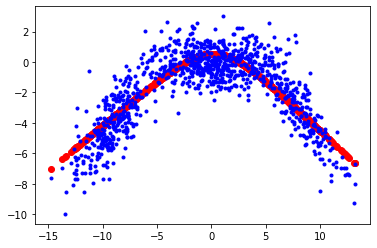

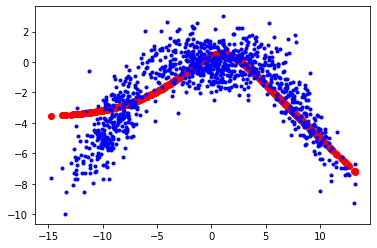

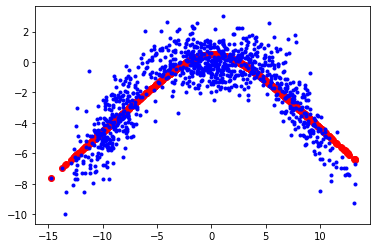

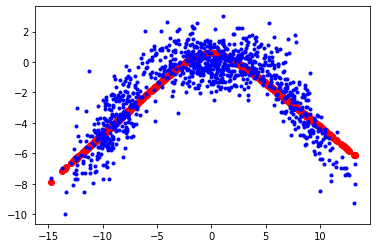

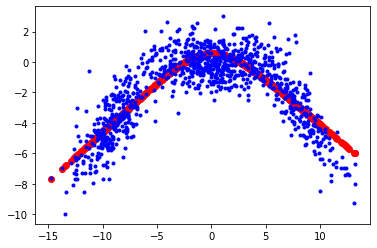

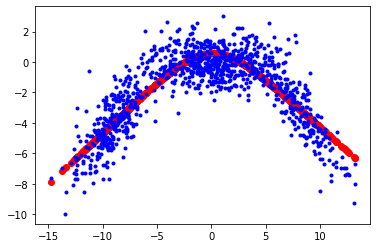

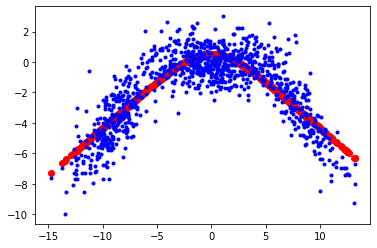

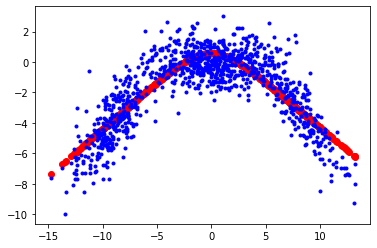

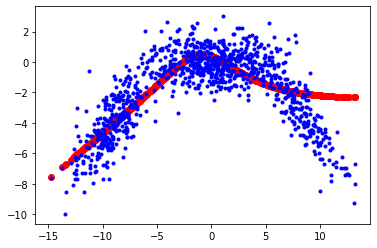

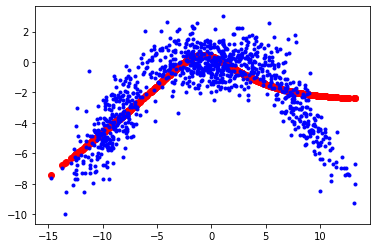

In [24]:
p_hat = tenFoldCrossVal(d4train1000_data)

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 5         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 21us/step
[1.4446783990859986, 1.4446780681610107]


AssertionError: 
Arrays are not almost equal to 1 decimals

Mismatched elements: 8961 / 10000 (89.6%)
Max absolute difference: 8.002851
Max relative difference: 8804.79400168
 x: array([[-0.9],
       [-3.7],
       [-3.1],...
 y: array([[ 0.8],
       [-4.6],
       [-3. ],...

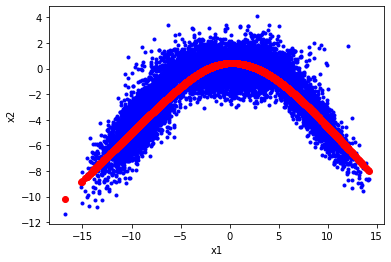

In [35]:
fitAndTest(p_hat, d4train1000_data.T, d4test10k_data.T)